In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from sklearn import metrics
import torch

from scDLM import data, layers, models

In [17]:
attention_layers=2
num_rel_pos_features=66
conv_layers=6
conv_repeat=1
kernel_number=1024
kernel_length=7
filter_number=512
filter_size=5
pooling_size=2
learning_rate=1e-4
h_layers=4
hidden_size=256

trainloader, valloader, testloader = data.load_data()
single_model = models.Transformer(
        kernel_number=kernel_number,
        kernel_length=kernel_length,
        filter_number=filter_number,
        filter_size=filter_size,
        pooling_size=pooling_size,
        conv_layers=conv_layers,
        conv_repeat=conv_repeat,
        attention_layers=attention_layers,
        hidden_size=hidden_size,
        dropout=0.2,
        h_layers=h_layers,
        pooling_type="avg",
        learning_rate=learning_rate,
        num_rel_pos_features=num_rel_pos_features,
)

In [23]:
trainer = pl.Trainer(
    devices=[3],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

checkpoint_path = '../output/tf/2_66_6_1_1024_7_512_5_2_0.0001_4_256/epoch=5-step=576.ckpt'
predictions = trainer.predict(single_model, dataloaders=[testloader], ckpt_path=checkpoint_path)
predictions = torch.cat(predictions, dim=0).cpu().numpy()

all_pred = predictions[:, :2714]
all_true = predictions[:, 2714:]

all_auc_score = []
for i in range(2714):  # the number of cells
    truth = all_true[:, i]
    pred = all_pred[:, i]
    try:
        score = metrics.roc_auc_score(truth, pred)
        all_auc_score.append(score)
    except ValueError:
        pass

print(all_auc_score)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ../output/tf/2_66_6_1_1024_7_512_5_2_0.0001_4_256/epoch=5-step=576.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at ../output/tf/2_66_6_1_1024_7_512_5_2_0.0001_4_256/epoch=5-step=576.ckpt


Predicting DataLoader 0: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  114            	|  1.8574         	

[0.6849249308274997, 0.56180760100233, 0.5973706736667903, 0.7017668776371307, 0.6446522633346873, 0.6613946879100515, 0.6624067442554461, 0.6012424462170655, 0.6754842419737155, 0.6520989318963097, 0.6054172316035992, 0.5992378048780488, 0.6752238137869293, 0.5891511031231278, 0.6393395957870766, 0.5851861842558369, 0.6084566470553276, 0.606032677000419, 0.6705930259714595, 0.5737005913476502, 0.6639702463970247, 0.6447417179278144, 0.5682886935187078, 0.6648015202702702, 0.6691793476866227, 0.6110557562170466, 0.5456876456876456, 0.644012644744528, 0.6403439046515598, 0.6803504968383016, 0.6542660063671737, 0.6410679187595545, 0.6408676842458032, 0.5647864042564181, 0.6761372257958107, 0.67165820642978, 0.5859842081769152, 0.6753274174679715, 0.6639256458727159, 0.5927269145354253, 0.6388157894736841, 0.5965793277248638, 0.5475740654568015, 0.6689478685627595, 0.5751465186412175, 0.6610291061684699, 0.6326299620017786, 0.6136138463715954, 0.6435922396033777, 0.6141289743457802, 0.655

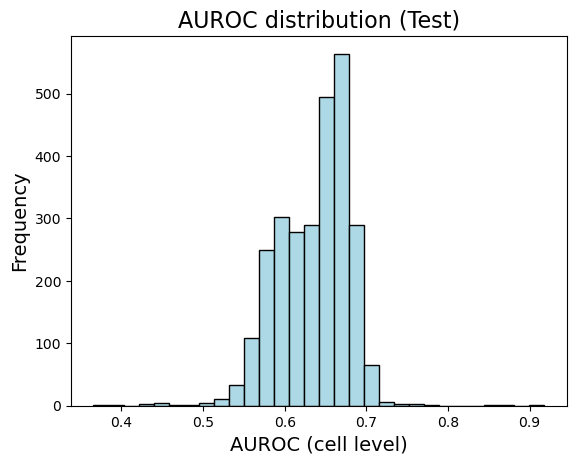

mean: 0.6354842024300529
54
12


In [41]:
import matplotlib.pyplot as plt

plt.hist(all_auc_score, edgecolor='black', bins=30, color='lightblue')
plt.xlabel('AUROC (cell level)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('AUROC distribution (Test)', fontsize=16)
plt.show()

print('mean:', np.mean(all_auc_score))

# count the number of cells with AUC > 0.9, and AUC <= 0.5
print(sum(np.array(all_auc_score) > 0.7))
print(sum(np.array(all_auc_score) <= 0.5))

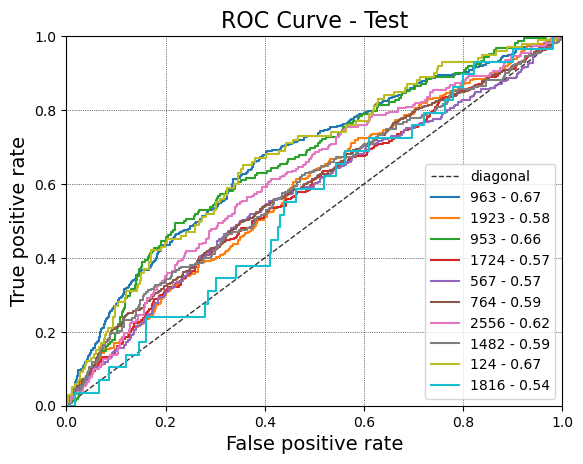

In [33]:
# get the indices of the cells with AUC > 0.7
# cell_indices = np.where(np.array(all_auc_score) > 0.75)[0]

# randomly select 5 cells
np.random.seed(0)
cell_indices = np.random.choice(2714, 10, replace=False)

plt.title(f"ROC Curve - Test", fontsize=16)

plt.grid(color="k", linestyle=":", linewidth=0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)

legend = []
for i in cell_indices:
    pred = all_pred[:, i]
    truth = all_true[:, i]
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    plt.plot(fpr, tpr)
    score = metrics.roc_auc_score(truth, pred)
    legend.append(f"{i} - {score:.2f}")

legend = ['diagonal'] + legend  
plt.legend(legend)
plt.show()

In [11]:
checkpoint_path = '../output/tf/2_66_6_1_1024_7_512_5_2_0.0001_4_256/epoch=5-step=576.ckpt'
trained_model = models.Transformer.load_from_checkpoint(checkpoint_path)
trained_model.eval()

final_layer = trained_model.out.weight.cpu().detach().numpy()
print(final_layer.shape)
print(final_layer[0][0:10])
print(single_model.out.weight.cpu().detach().numpy()[0][0:10])

(2714, 256)
[ 0.00294119  0.04532351 -0.05869607 -0.00600207  0.05251118 -0.06440709
 -0.02159479 -0.06301156 -0.00179113 -0.04261145]
[ 0.02676081 -0.04689544 -0.04293326 -0.02990697 -0.01709829  0.00711311
 -0.04228964  0.02618966 -0.0120787  -0.01021022]


/homes/gws/wz86/miniconda3/envs/scDLM/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2714, 2)


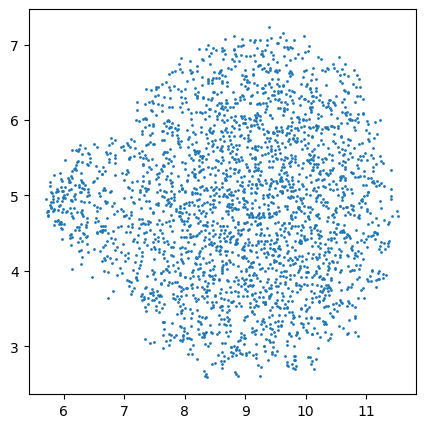

In [14]:
from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(final_layer)
# print(tsne.shape)

from umap import UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(final_layer)
print(proj_2d.shape)

plt.figure(figsize=(5, 5))
# create a legend to map cell type to color
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], s=1)
plt.show()